# Univariate time series classification using Signatures/Log signatures

In this notebook, we explore the classification results of signature/log signature features 114 datasets of the [UCR repository](https://arxiv.org/abs/1810.07758).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATASETS = [
    "ACSF1", "Adiac", "AllGestureWiimoteX", "AllGestureWiimoteY",
    "AllGestureWiimoteZ", "ArrowHead", "Beef", "BeetleFly", "BirdChicken",
    "BME", "Car", "CBF", "Chinatown", "ChlorineConcentration",
    "CinCECGTorso", "Coffee", "Computers", "CricketX", "CricketY",
    "CricketZ", "Crop", "DiatomSizeReduction",
    "DistalPhalanxOutlineAgeGroup", "DistalPhalanxOutlineCorrect",
    "DistalPhalanxTW", "DodgerLoopDay", "DodgerLoopGame",
    "DodgerLoopWeekend", "Earthquakes", "ECG200", "ECG5000", "ECGFiveDays",
    "ElectricDevices", "EOGHorizontalSignal", "EOGVerticalSignal",
    "EthanolLevel", "FaceAll", "FaceFour", "FacesUCR", "FiftyWords",
    "Fish", "FordA", "FordB", "FreezerRegularTrain", "FreezerSmallTrain",
    "Fungi", "GestureMidAirD1", "GestureMidAirD2", "GestureMidAirD3",
    "GesturePebbleZ1", "GesturePebbleZ2", "GunPoint", "GunPointAgeSpan",
    "GunPointMaleVersusFemale", "GunPointOldVersusYoung", "Ham",
    "HandOutlines", "Haptics", "Herring", "HouseTwenty", "InlineSkate",
    "InsectEPGRegularTrain", "InsectEPGSmallTrain", "InsectWingbeatSound",
    "ItalyPowerDemand", "LargeKitchenAppliances", "Lightning2",
    "Lightning7", "Mallat", "Meat", "MedicalImages", "MelbournePedestrian",
    "MiddlePhalanxOutlineAgeGroup", "MiddlePhalanxOutlineCorrect",
    "MiddlePhalanxTW", "MixedShapesRegularTrain", "MixedShapesSmallTrain",
    "MoteStrain", "NonInvasiveFatalECGThorax1",
    "NonInvasiveFatalECGThorax2", "OliveOil", "OSULeaf",
    "PhalangesOutlinesCorrect", "Phoneme", "PickupGestureWiimoteZ",
    "PigAirwayPressure", "PigArtPressure", "PigCVP", "PLAID", "Plane",
    "PowerCons", "ProximalPhalanxOutlineAgeGroup",
    "ProximalPhalanxOutlineCorrect", "ProximalPhalanxTW",
    "RefrigerationDevices", "Rock", "ScreenType", "SemgHandGenderCh2",
    "SemgHandMovementCh2", "SemgHandSubjectCh2", "ShakeGestureWiimoteZ",
    "ShapeletSim", "ShapesAll", "SmallKitchenAppliances", "SmoothSubspace",
    "SonyAIBORobotSurface1", "SonyAIBORobotSurface2", "StarLightCurves",
    "Strawberry", "SwedishLeaf", "Symbols", "SyntheticControl",
    "ToeSegmentation1", "ToeSegmentation2", "Trace", "TwoLeadECG",
    "TwoPatterns", "UMD",
    "UWaveGestureLibraryAll", "UWaveGestureLibraryX",
    "UWaveGestureLibraryY", "UWaveGestureLibraryZ", "Wafer", "Wine",
    "WordSynonyms", "Worms", "WormsTwoClass", "Yoga",
]

The results are already stored in the Github repository under `results/ucr`, we only need run load them into this notebook.

In [3]:
def load_results(filename, results_dir='./results/ucr', datasets=DATASETS):
    r = []
    missing = []
    names = []
    for d in DATASETS:
        try:
            data = pd.read_pickle(f'{results_dir}/{d}/{filename}')
            names.append(d)
            r.append(data)
        except FileNotFoundError:
            missing.append(d)
    return (pd.concat(r, keys=names), missing)


Let's load the results for **log signatures + XGBoost** and **signatures + logistic regression**.
The results are obtained using **default** `sklearn.linear_model.LogisticRegression` and `xgboost.XGBClassifier` settings. 

In [4]:
lgr, lgrmissing = load_results('sig_LogisticRegression_2_3_4_5_6_7_8_9_10.pkl')
xgb, xgbmissing = load_results('logsig_XGBClassifier_2_3_4_5_6_7_8_9_10.pkl')

Let's inspect results on a single dataset:

In [5]:
lgr.loc['Herring']

,leadlag,timejoined,timeindexed,leadlag_elapsed,timejoined_elapsed,timeindexed_elapsed
2,0.562500,0.640625,0.640625,0.005758,0.007644,0.018551
3,0.593750,0.718750,0.640625,0.012811,0.014471,0.023167
4,0.578125,0.640625,0.640625,0.022009,0.024327,0.027862
5,0.578125,0.593750,0.562500,0.039215,0.039815,0.035772
6,0.625000,0.593750,0.578125,0.068118,0.070439,0.050806
7,0.562500,0.609375,0.578125,0.137824,0.139892,0.087163
8,0.625000,0.625000,0.578125,0.271212,0.285807,0.162024
9,0.578125,0.609375,0.625000,0.550723,0.571800,0.313101
10,0.609375,0.593750,0.562500,1.183853,1.225056,0.653711


These are the classification scores of signatures + logistic regression on the 
Herring dataset. The index represents the truncation level of signature features.
The elapsed training time is also included.

We'll only consider the actual classifcation scores:

In [6]:
lgr = lgr[['leadlag', 'timejoined', 'timeindexed']]
xgb = xgb[['leadlag', 'timejoined', 'timeindexed']]

## Comparison between the classifiers
Let's get a single score for each classifier by taking the maximum over all truncation levels and path embedding methods:

In [7]:
compare = pd.concat([
    lgr.max(level=0).max(axis=1),
    xgb.max(level=0).max(axis=1),
], axis=1, sort=True).dropna()
compare.columns = ["LogisticRegression", "XGBoost"]

In [8]:
compare.head()

,LogisticRegression,XGBoost
ACSF1,0.610000,0.770000
Adiac,0.516624,0.565217
ArrowHead,0.748571,0.668571
BME,0.986667,0.966667
Beef,0.833333,0.600000


There are 114 datasets in this dataframe. We can compute the mean classification score over all the datasets for the two classifiers:

In [9]:
compare.mean()

LogisticRegression    0.776785
XGBoost               0.729903
dtype: float64

We see that logistic regression on signature features has better scores than XGBoost on log signature features. To visualize this, we can plot a scatter graph:

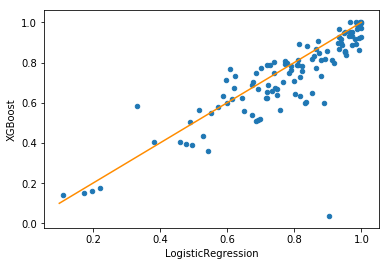

In [10]:
ax = compare.plot.scatter(x='LogisticRegression', y='XGBoost')
ax.plot([0.1,1],[0.1,1], c='darkorange') # add diagonal

Each point in this figure represents the classification scores of a single dataset.
That is, if we have a point $(x,y)$ in the figure, then $x$ is the classification score of logistic regression for that dataset while $y$ is the classification score of XGBoost for that dataset.

Therefore, points that appear below the diagonal correspond to datasets on which logistic regression performs better; and vice versa.

We see that most points appear below the diagonal, which seems to imply that **logistic regression + signature features** perform better.

## Comparison with Benchmarks

Next, we compare these results with benchmark results of several
state-of-the-art time series classification algorithms provided by the
UCR repository.

First, we download the benchmark results from www.timeseriesclassification.com.

In [11]:
def get_benchmarks(url='http://www.timeseriesclassification.com/singleTrainTest.csv'):
    df = pd.read_csv(url)
    df = df.set_index('Unnamed: 0', drop=True)
    df.index.name = 'Dataset'
    # Fix a few mismatches between dataset names
    df = df.rename(index={
        'CinCECGtorso': 'CinCECGTorso',
        'StarlightCurves': 'StarLightCurves'
    })
    return df

bm = get_benchmarks()

In [12]:
bm.head()

,NB,C45,SVML,SVMQ,BN,RandF,RotF,MLP,Euclidean_1NN,DTW_R1_1NN,...,BOSS,TSF,TSBF,LPS,ACF,PS,EE,CID_DTW,Flat-COTE,HIVE-COTE
Dataset,,,,,,,,,,,,,,,,,,,,,
Adiac,0.562660,0.542199,0.442455,0.762148,0.501279,0.636829,0.774936,0.736573,0.611253,0.603581,...,0.764706,0.731458,0.769821,0.769821,0.664962,0.751918,0.664962,0.624041,0.790281,0.810742
ArrowHead,0.542857,0.605714,0.731429,0.742857,0.571429,0.714286,0.737143,0.708571,0.800000,0.702857,...,0.834286,0.725714,0.754286,0.782857,0.645714,0.474286,0.811429,0.828571,0.811429,0.862857
Beef,0.666667,0.533333,0.900000,0.933333,0.600000,0.733333,0.866667,0.600000,0.666667,0.633333,...,0.800000,0.766667,0.566667,0.600000,0.733333,0.733333,0.633333,0.633333,0.866667,0.933333
BeetleFly,0.750000,0.900000,0.800000,0.850000,0.850000,0.800000,0.900000,0.800000,0.750000,0.700000,...,0.900000,0.750000,0.800000,0.800000,0.650000,0.850000,0.750000,0.750000,0.800000,0.950000
BirdChicken,0.550000,0.800000,0.650000,0.800000,0.600000,0.750000,0.850000,0.600000,0.550000,0.750000,...,0.950000,0.800000,0.900000,1.000000,0.850000,0.950000,0.800000,0.750000,0.900000,0.850000


We see that the benchmarks contains results for 37 different algorithms.
Let's join these with our results:

In [13]:
df = pd.concat([bm, compare], axis=1, sort=True).dropna(thresh=3) # drop row if less than 3 non-NA values

The benchmarks only contain results for 85 out of 128 datasets.
This is a subset of our results on 114 datasets.

Let's look at how often each algorithm performs the best on the datasets
to obtain a rough ranking between the algorithms.

In [14]:
df.idxmax(axis=1).value_counts()

HIVE-COTE             20
ST                    10
BOSS                   6
SAXVSM                 6
LogisticRegression     5
Flat-COTE              4
MLP                    3
DTW_R1_1NN             3
EE                     3
SVMQ                   3
RotF                   3
SVML                   3
FS                     2
LS                     2
MSM_1NN                2
RandF                  2
NB                     1
DDTW_Rn_1NN            1
WDDTW_1NN              1
DD_DTW                 1
WDTW_1NN               1
ACF                    1
LPS                    1
TWE_1NN                1
dtype: int64

We see that [HIVE-COTE](https://dl.acm.org/citation.cfm?id=3182382) performs the best on 20 datasets
whereas our LogisticRegression + signatures performs the best on 5 datasets.
There is no dataset on which log signatures + XGBoost performs the best.

Let's visually compare HIVE-COTE with our classifiers through a scatter plot.

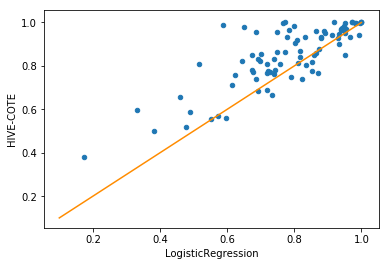

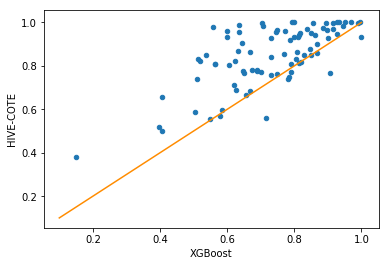

In [15]:
ax = df.plot.scatter(x='LogisticRegression', y='HIVE-COTE')
ax.plot([0.1,1],[0.1,1], c='darkorange') # add diagonal

ax = df.plot.scatter(x='XGBoost', y='HIVE-COTE')
ax.plot([0.1,1],[0.1,1], c='darkorange') # add diagonal

We see that in most cases, the HIVE-COTE classifier outperforms our results.
However, there is a handful of datasets in which signatures have an edge.
Since HIVE-COTE is an ensemble of classifiers and feature sets, it might
be interesting to see if integrating signature features into this ensemble
will boost its performance.